In [2]:
import warnings
warnings.filterwarnings("ignore")
from custom_libs import db
from custom_libs import preprocessing
from custom_libs import classification
from custom_libs import plotting
from custom_libs import best_restaurants
from custom_libs import dump

In [3]:
text_column_name = 'review'
cleaned_text_column_name = 'review_cleaned'

In [4]:
df = db.get_dataset("McDonald_s_Reviews")
preprocessing.add_id_column(df, columns=["latitude", "longitude"])
preprocessing.add_rating_number_column(df)
proprocessing_function = preprocessing.preprocess_text
preprocessing.preprocess_dataframe(df, text_column_name, cleaned_text_column_name, proprocessing_function)
df.head(2)

Number of unique ids:  40


reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   

                                       store_address   latitude  longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   

                                              review   rating  rating_number  \
0  Why does it look like someone spit on my food?...   1 star              1   
1  It'd McDonalds. It is what it is as far as the...  4 stars              4   

   id                                     review_cleaned  
0   9  look like someone spit food normal transaction...  
1   9  far food atmosphere go staff make difference f...

In [4]:
sentiment_our_column_name = 'sentiment_our'
sentiment_auto_column_name = 'sentiment_auto'

In [5]:
# Our model
model = dump.load_model("model_chat")
vectorizer = dump.load_model("vectorizer_chat")
df[sentiment_our_column_name] = model.predict(vectorizer.transform(df[cleaned_text_column_name]))

# SentimentIntensityAnalyzer model
classification.append_sentiment_for_each_row(df, cleaned_text_column_name, new_column_name=sentiment_auto_column_name)

# Results
df[[cleaned_text_column_name, sentiment_auto_column_name, sentiment_our_column_name]]

Loading model from: dump_models/model_chat.pkl
Loading model from: dump_models/vectorizer_chat.pkl


review_cleaned sentiment_auto  \
0      look like someone spit food normal transaction...       Positive   
1      far food atmosphere go staff make difference f...       Positive   
2      make mobile order get speaker checked line mov...       Negative   
3      mc crispy chicken sandwich customer service qu...        Neutral   
4      repeat order time drive thru still manage mess...       Negative   
...                                                  ...            ...   
33391                                        treat badly       Negative   
33392                                       service good       Positive   
33393                               remove hunger enough       Negative   
33394                       good lately become expensive       Positive   
33395                                     take good care       Positive   

      sentiment_our  
0           Neutral  
1          Positive  
2          Negative  
3          Positive  
4           Neutral  
...             ...  
33391       Neutral  
33392       Neutral  
33393       Neutral  
33394       Neutral  
33395       Neutral  

[33396 rows x 3 columns]

In [6]:
# Rows with different sentiment
df_differences = df[df[sentiment_our_column_name] != df[sentiment_auto_column_name]]
df_differences.shape

(14652, 15)

In [12]:
df_differences = df_differences[[text_column_name, sentiment_auto_column_name, sentiment_our_column_name]]
db.save_dataset(df_differences, "McDonald_s_Reviews_differences")
df_differences.sample(20)

review sentiment_auto  \
9547   Dirty inside atmosphere,  food luke warm and f...       Negative   
1715                                               Good        Positive   
17853                                              Good        Positive   
3019   Food took longer than I'd expect at a fast foo...       Positive   
32012   Sick...sick...sick!!! I was sick for two days...       Negative   
17338  Never eating here again was on my lunch break ...       Negative   
12617  McDonalds aint been the same since the end of ...       Negative   
9286   It's fast and convenient, what more could you ...       Positive   
17247  Please make sure you check your order,  I was ...       Positive   
32435  Long wait in drive thru. Ordered double cheese...       Negative   
4146   At @McDonalds was trying to pick up an order f...       Positive   
14214  This is, hands down, the slowest McDonald's I ...       Positive   
31886                     My express place going to work        Neutral   
15325                                              Good        Positive   
18354  Just like any other McDonalds. The bathrooms a...       Positive   
8007   Food was way too salty line was way too long s...        Neutral   
15131                              Good to go in and out       Positive   
23309  I waited in the drive thru line for half an ho...       Negative   
26054  I don't recommend this place super poor custom...       Positive   
5249   Order took longer than usual, and was missing ...       Positive   

      sentiment_our  
9547       Positive  
1715        Neutral  
17853       Neutral  
3019       Negative  
32012       Neutral  
17338      Positive  
12617       Neutral  
9286        Neutral  
17247       Neutral  
32435      Positive  
4146        Neutral  
14214       Neutral  
31886      Positive  
15325       Neutral  
18354      Negative  
8007       Negative  
15131       Neutral  
23309       Neutral  
26054      Negative  
5249        Neutral

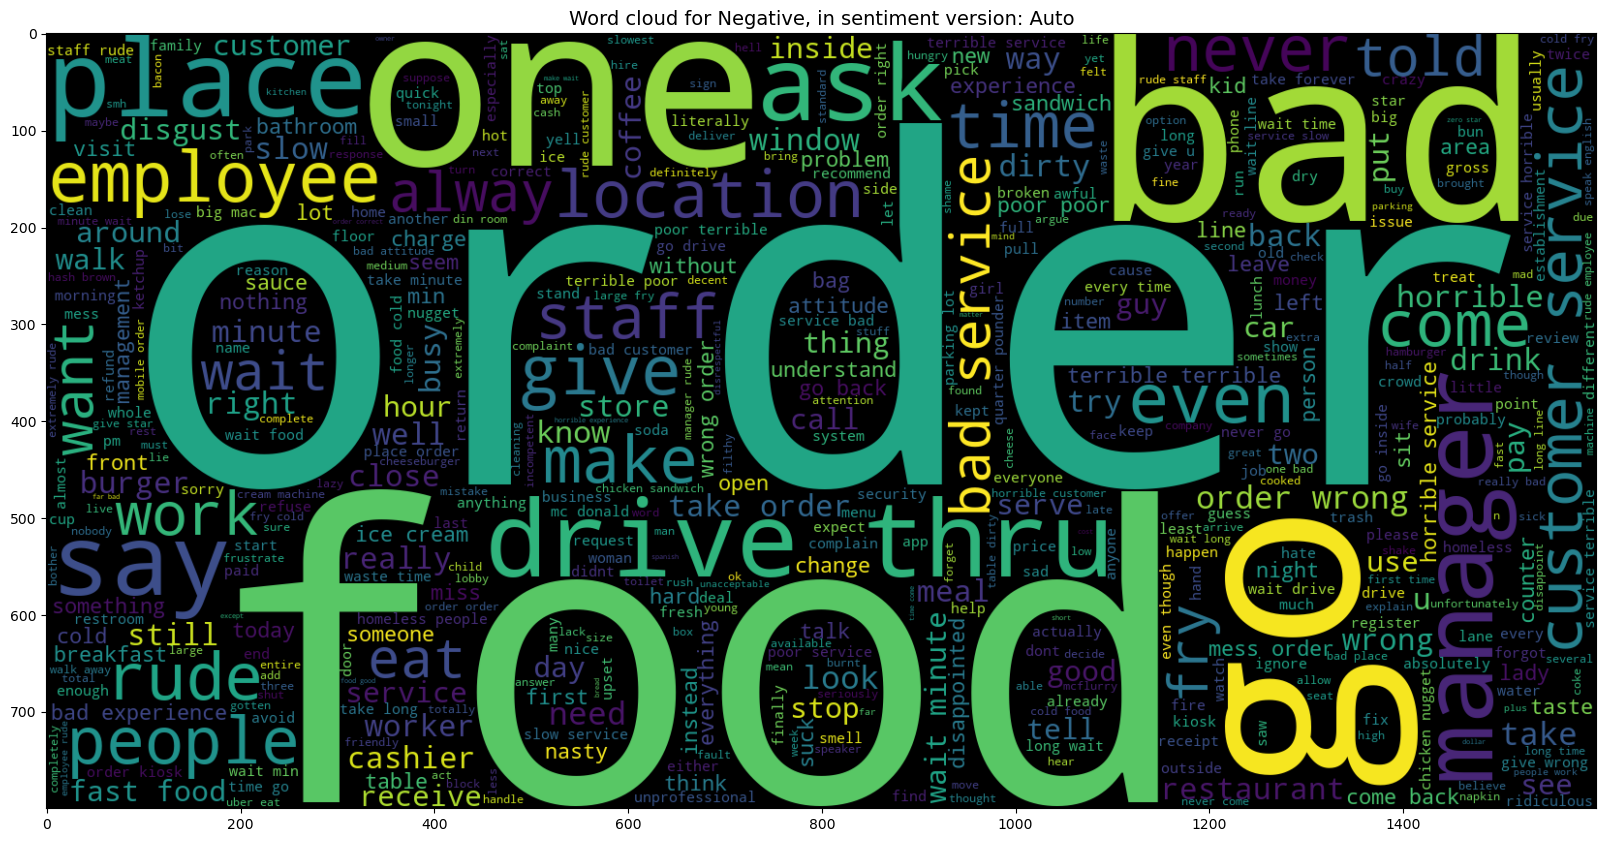

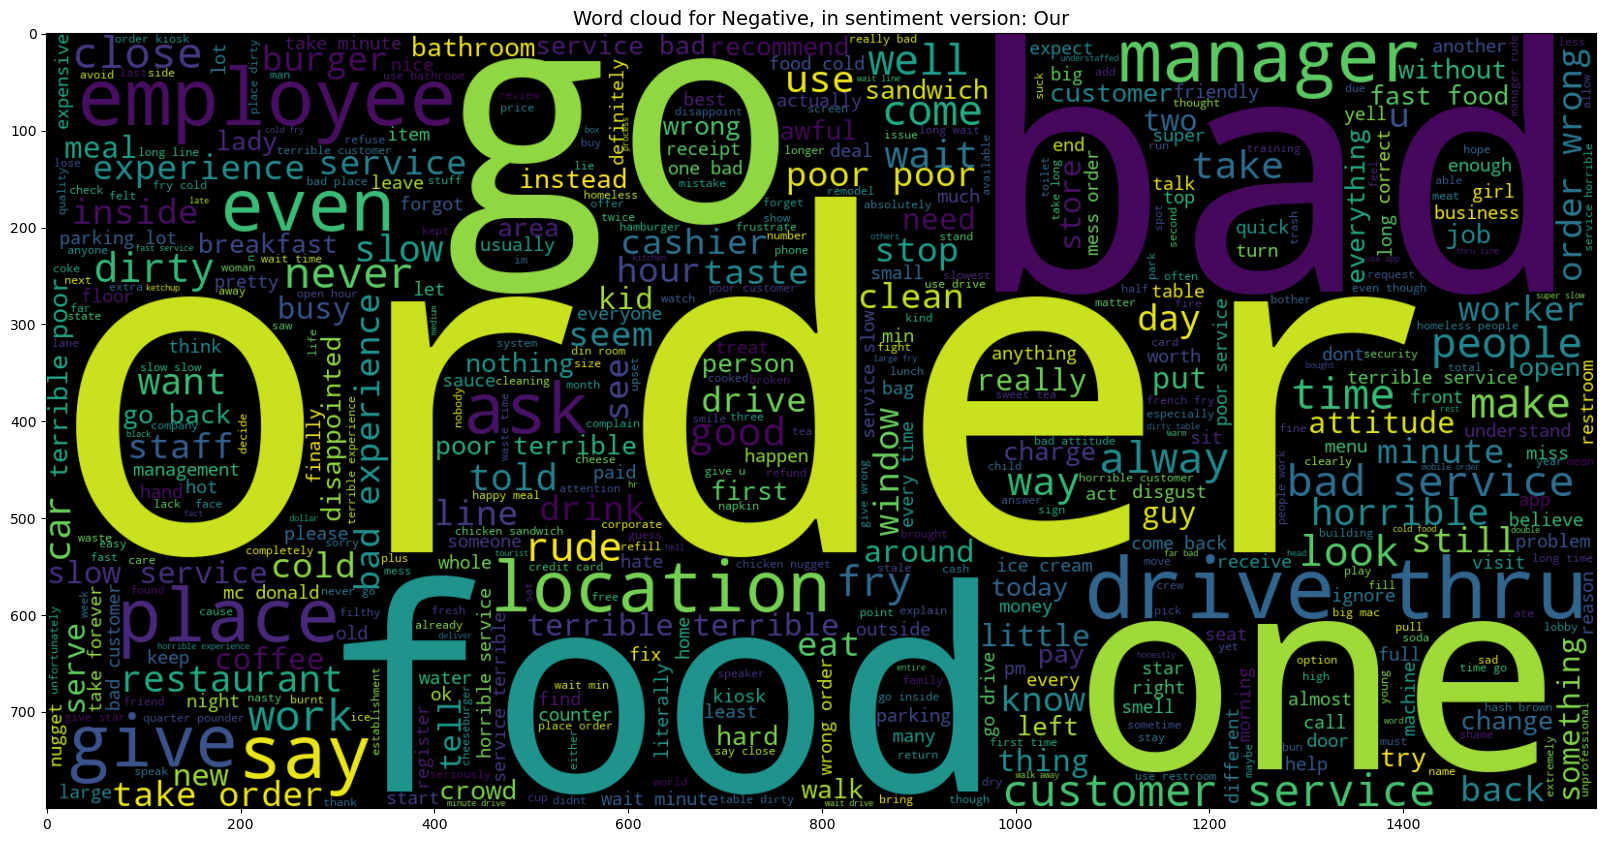

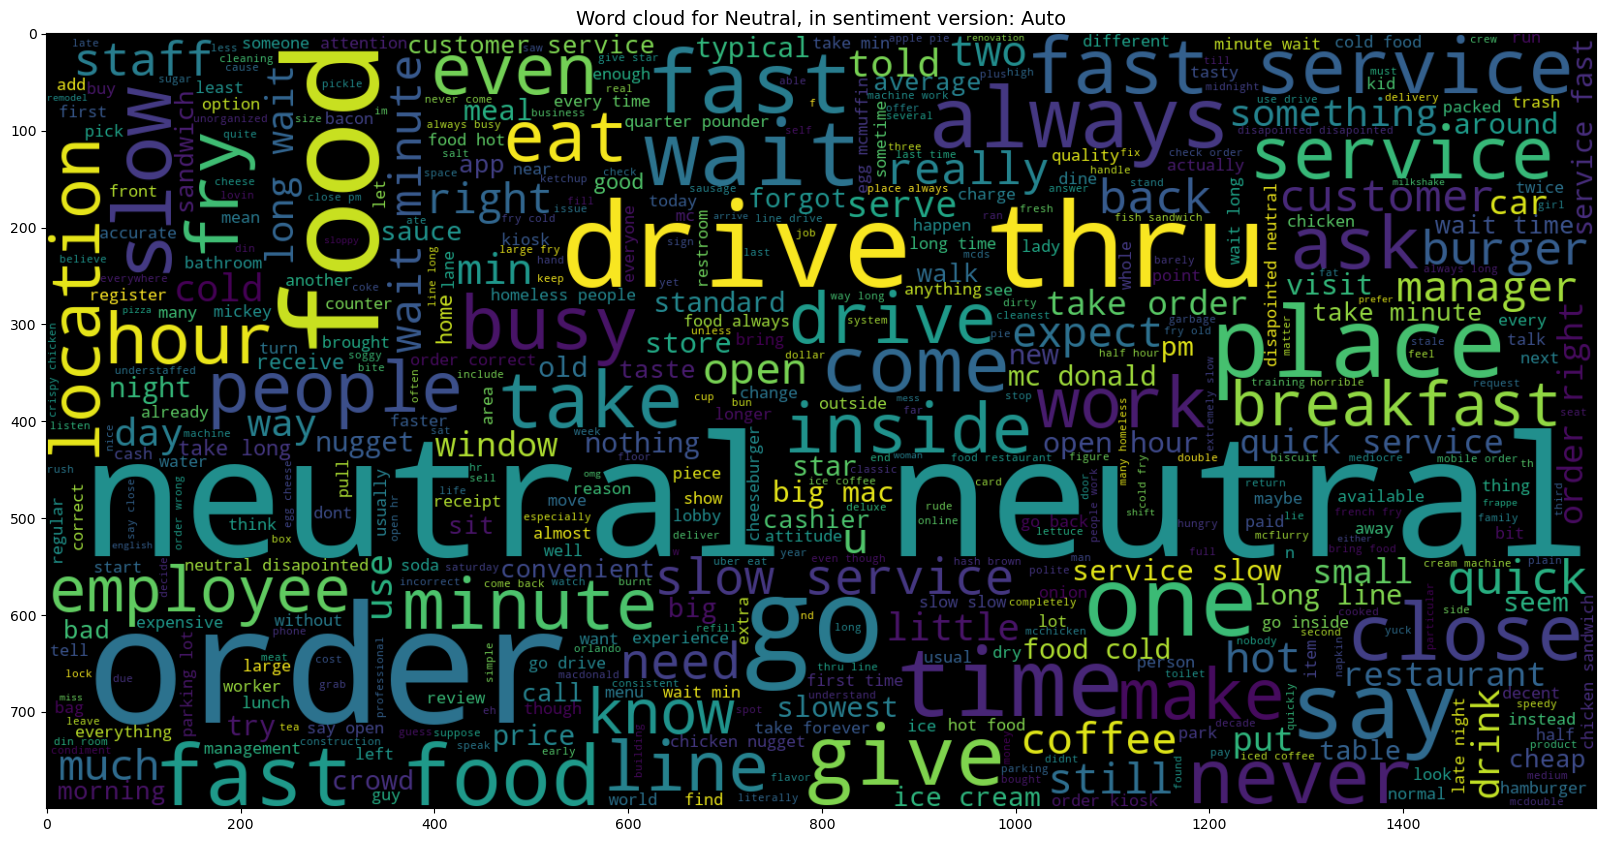

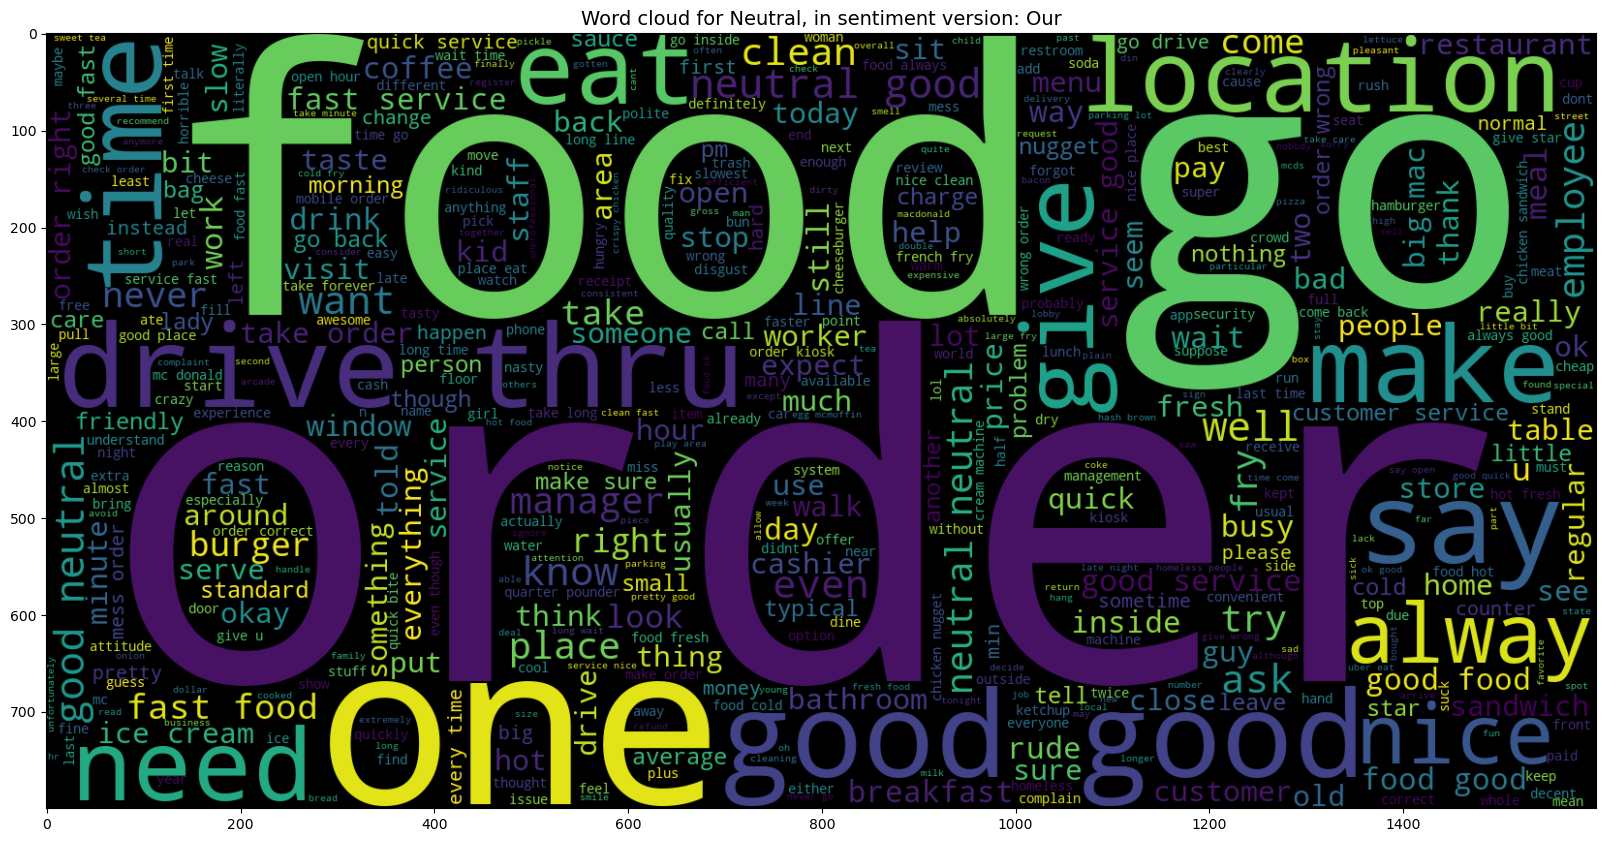

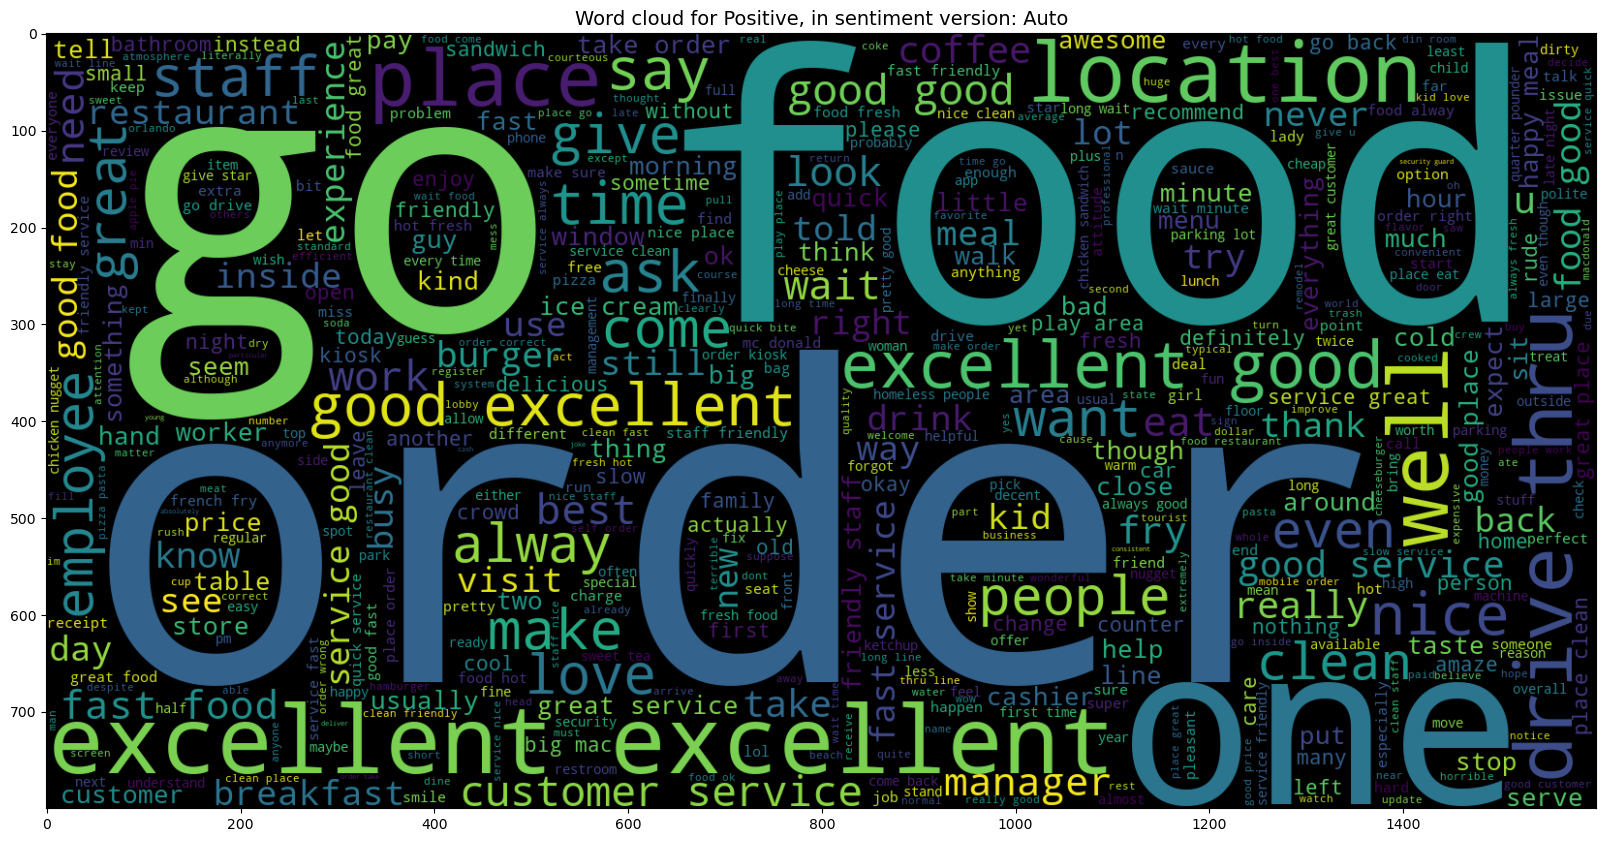

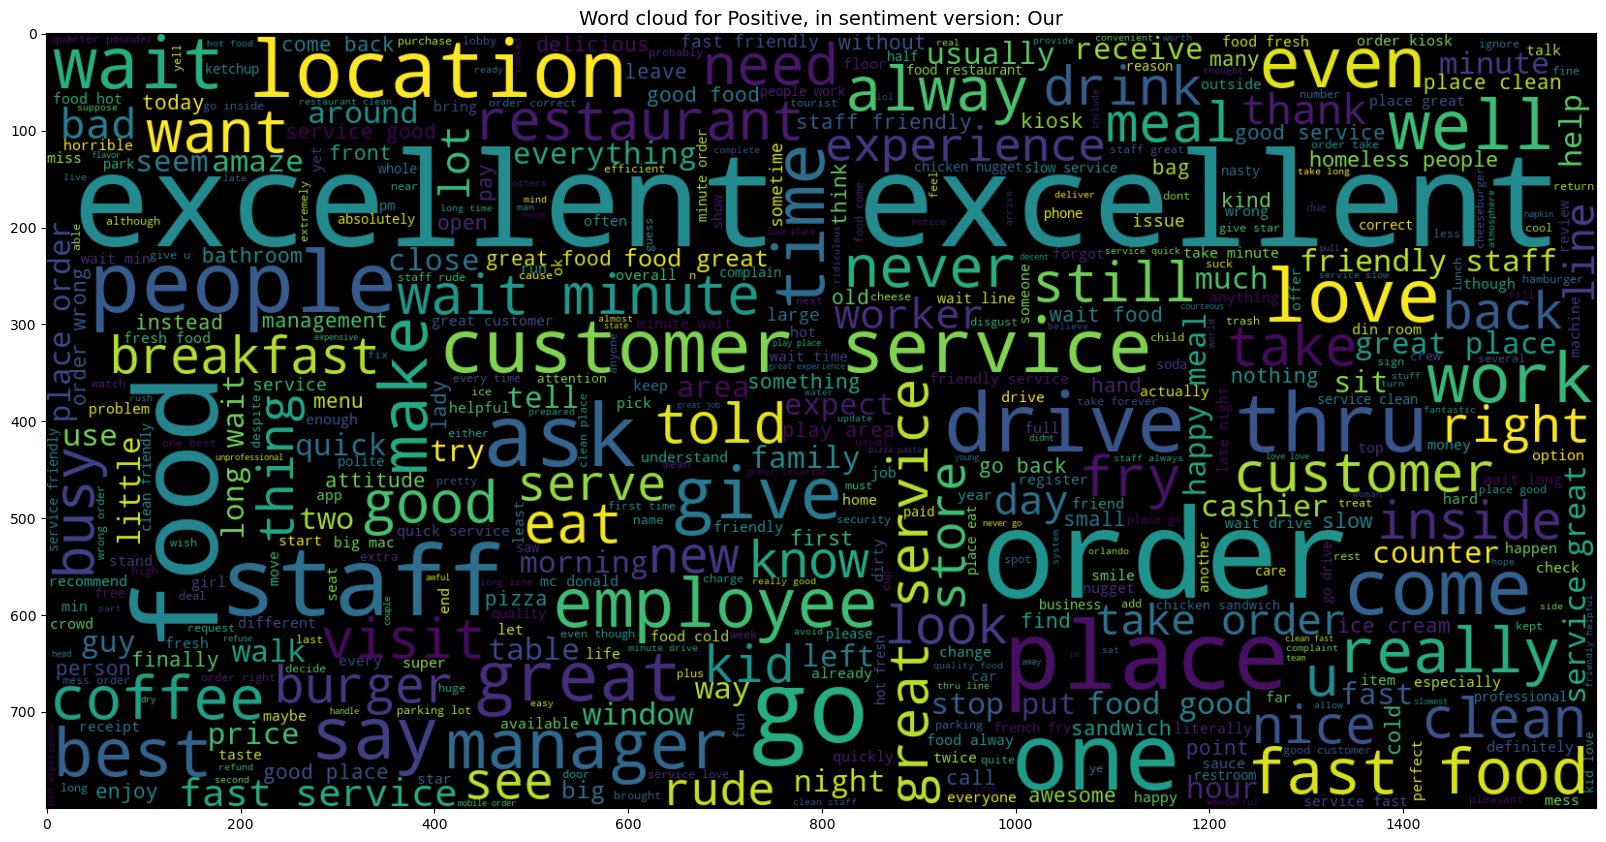

In [9]:
def plot_sentiment_word_clouds(df):
    for sentiment in classification.Sentiment.get_all():
        df_sentiment = df[(df[sentiment_auto_column_name]==sentiment)]
        plotting.plot_word_cloud(df_sentiment, sentiment, cleaned_text_column_name, plt_name="Auto")
        df_sentiment = df[(df[sentiment_our_column_name]==sentiment)]
        plotting.plot_word_cloud(df_sentiment, sentiment, cleaned_text_column_name, plt_name="Our")

plot_sentiment_word_clouds(df)

In [10]:
current_position = [30.460718, -97.792874]
max_distance = 20
best_rated_restaurant = best_restaurants.select_best_restaurant_from_stars(df, current_position, max_distance)
best_rated_restaurant

store_address   latitude  longitude
id                                                                    
8   8500 US-290, Austin, TX 78724, United States  30.329135 -97.660629

In [11]:
best_clf_column = sentiment_auto_column_name
best_feeling_restaurant = best_restaurants.select_best_restaurant_from_sentiment(df, current_position, max_distance, sentiment_column=best_clf_column)
best_feeling_restaurant

store_address   latitude  longitude
id                                                                         
9   13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874